In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

# 4.1 - Principal Component Analysis

Rotation Angle: -57 degrees
Rotation Angle: -23 degrees
Rotation Angle: -69 degrees
Rotation Angle: -128 degrees
Rotation Angle: -86 degrees
Rotation Angle: -89 degrees
Rotation Angle: -90 degrees
Rotation Angle: 44 degrees
Rotation Angle: 5 degrees
Rotation Angle: -127 degrees
Rotation Angle: -121 degrees
Rotation Angle: 0 degrees
Rotation Angle: -128 degrees
Rotation Angle: -90 degrees
Rotation Angle: -111 degrees
Rotation Angle: -90 degrees
Rotation Angle: -115 degrees
Rotation Angle: 42 degrees
Rotation Angle: -7 degrees
Rotation Angle: -84 degrees
Rotation Angle: -89 degrees
Rotation Angle: 2 degrees
Rotation Angle: -58 degrees
Rotation Angle: -55 degrees
Rotation Angle: -125 degrees
Rotation Angle: -126 degrees
Rotation Angle: -113 degrees
Rotation Angle: 41 degrees
Rotation Angle: -94 degrees
Rotation Angle: -90 degrees
Rotation Angle: -114 degrees
Rotation Angle: -98 degrees
Rotation Angle: -119 degrees
Rotation Angle: 33 degrees
Rotation Angle: -118 degrees
Rotation Angle: -92

/tmp/ipykernel_305208/733760768.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


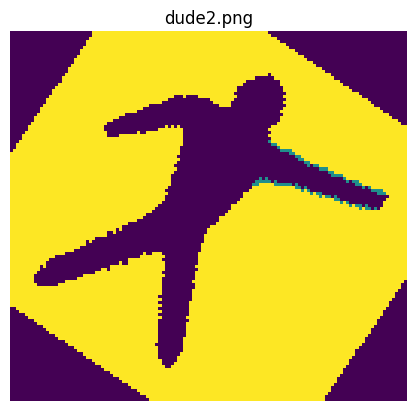

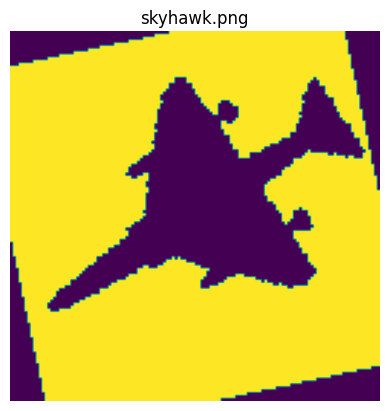

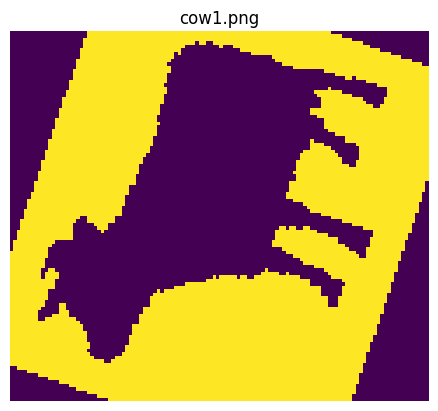

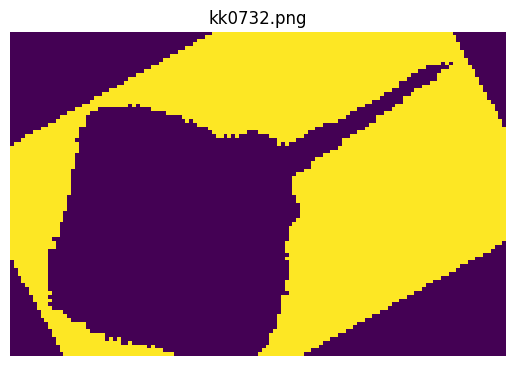

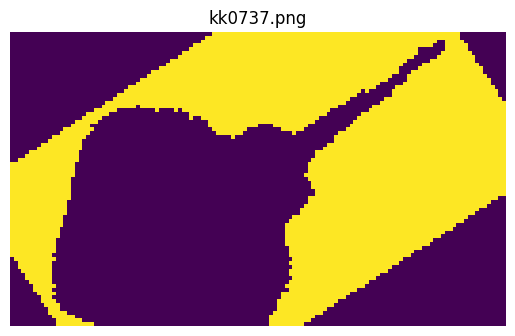

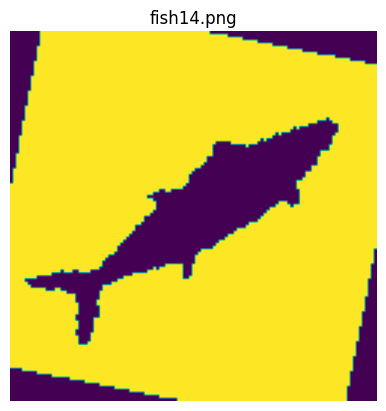

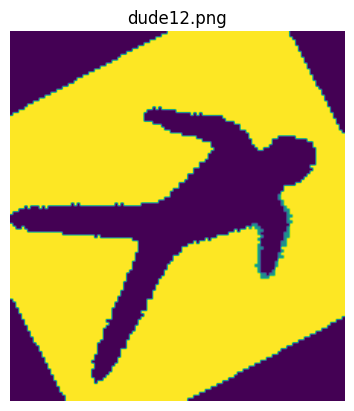

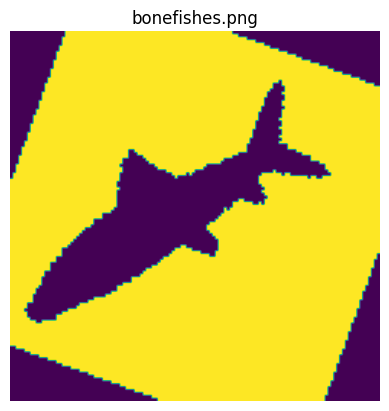

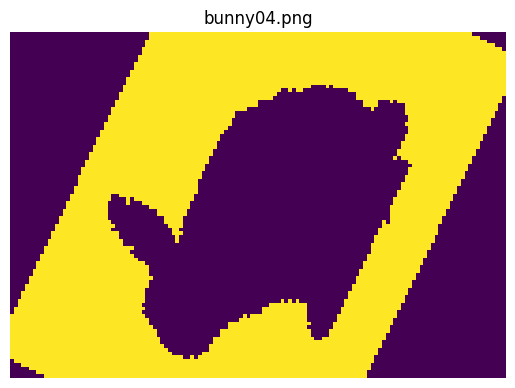

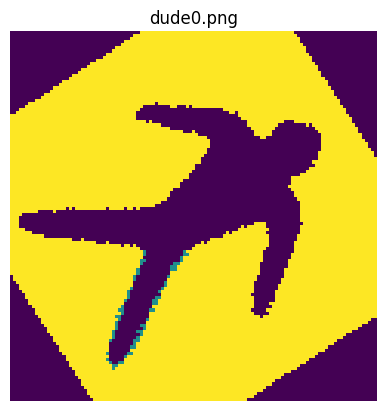

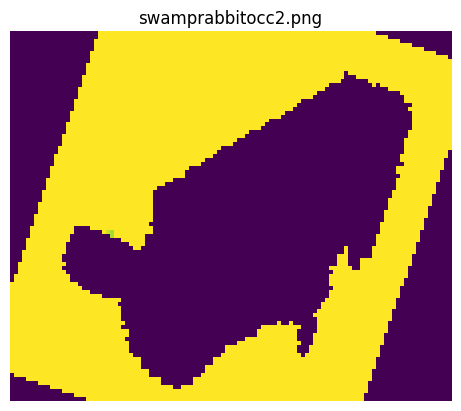

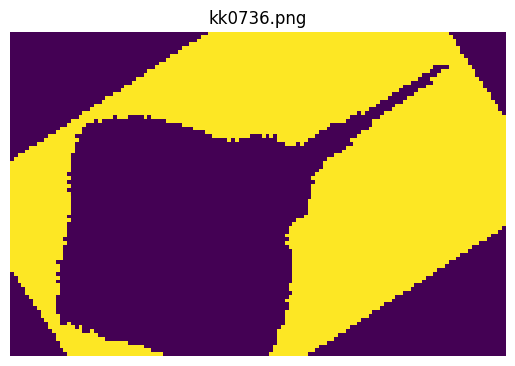

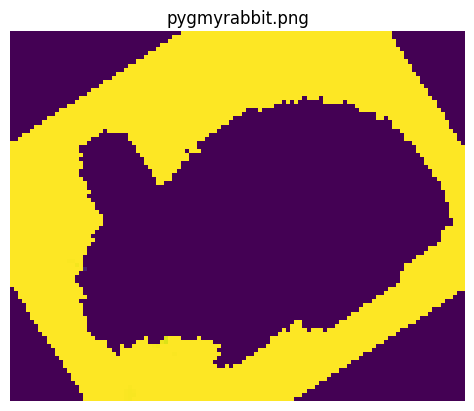

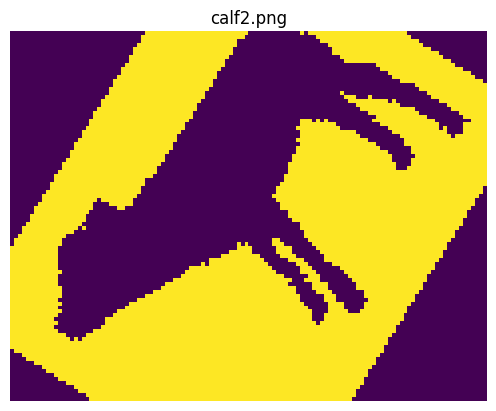

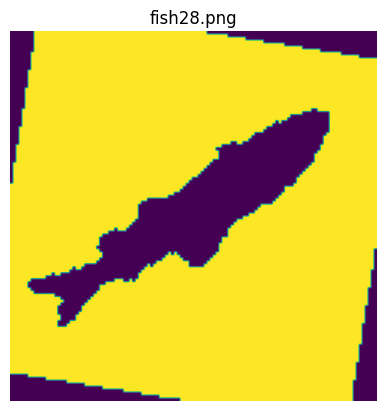

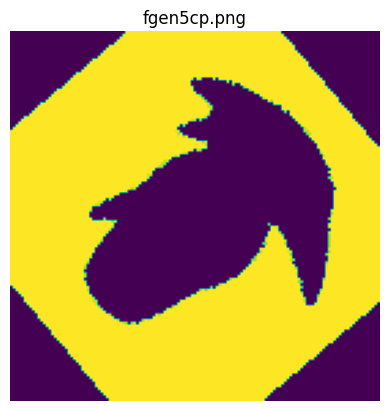

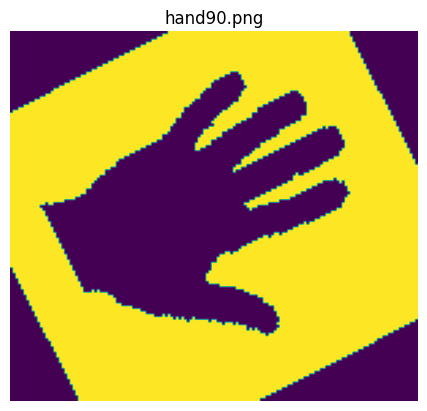

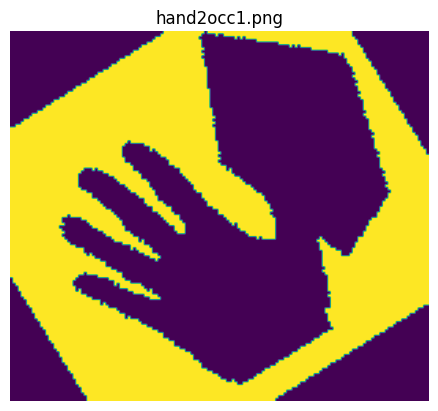

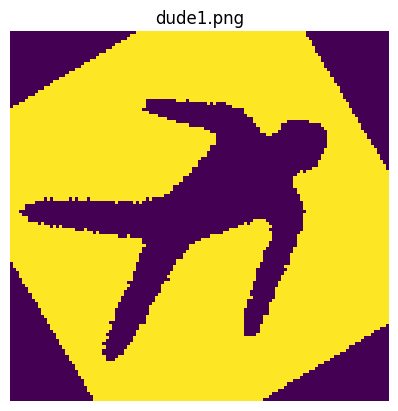

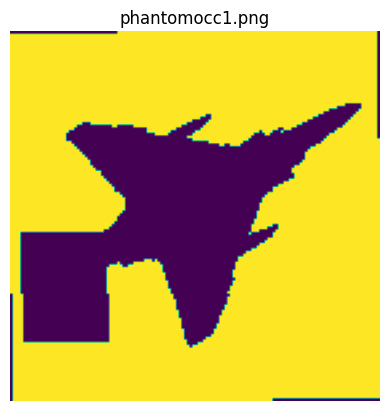

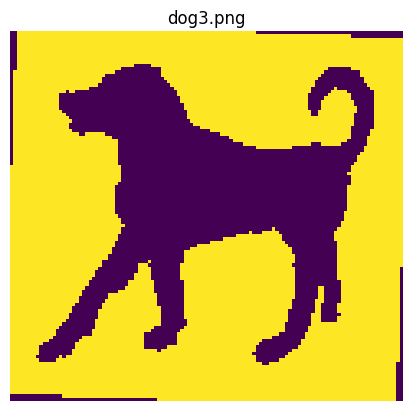

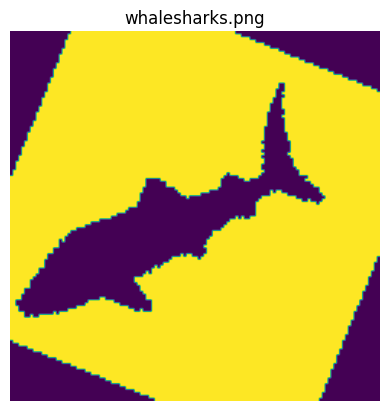

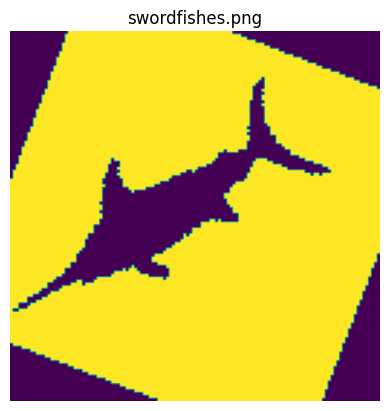

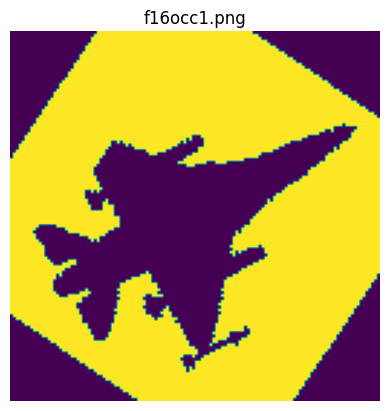

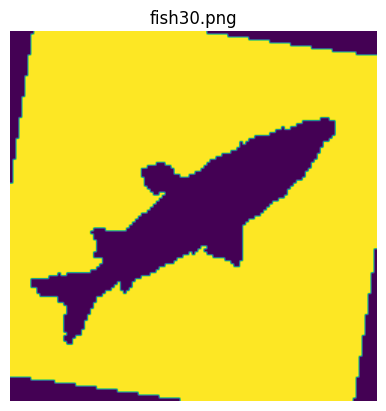

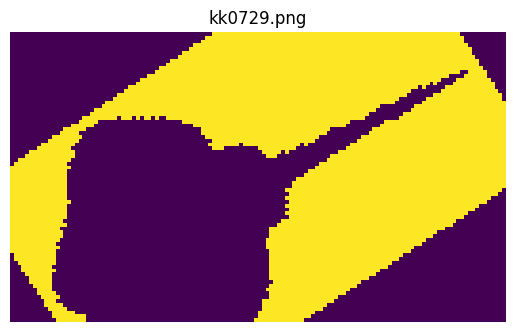

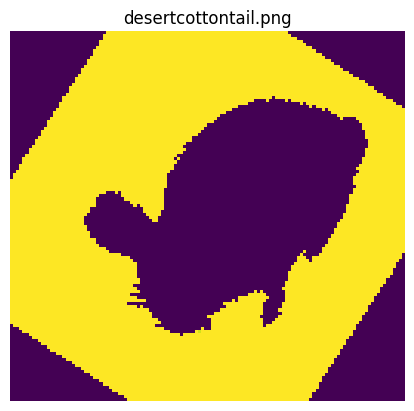

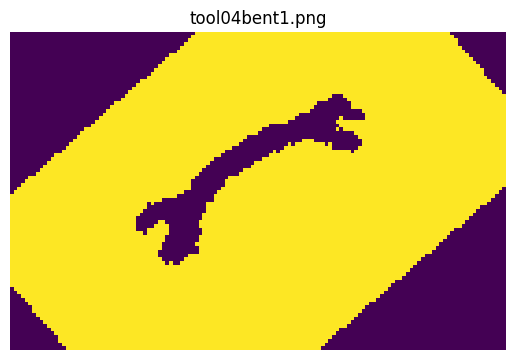

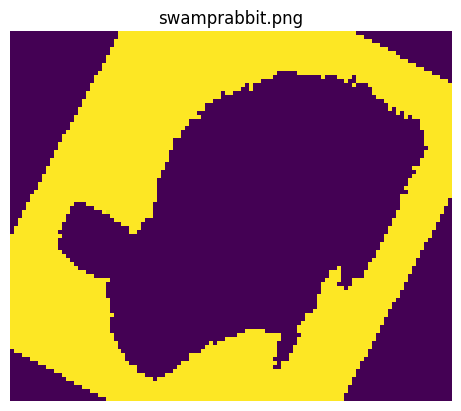

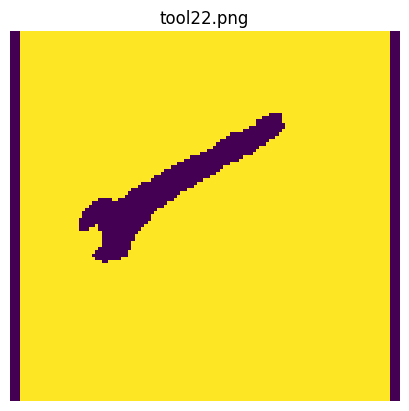

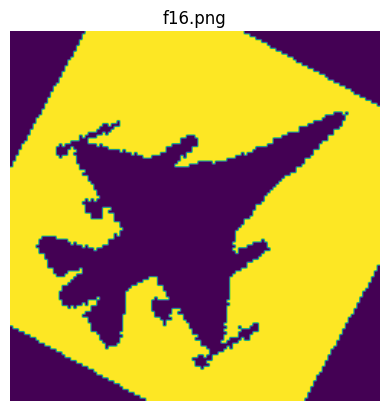

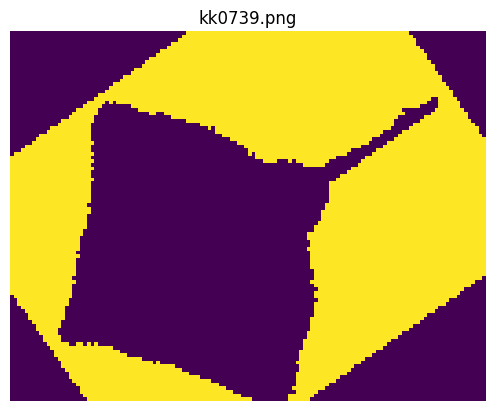

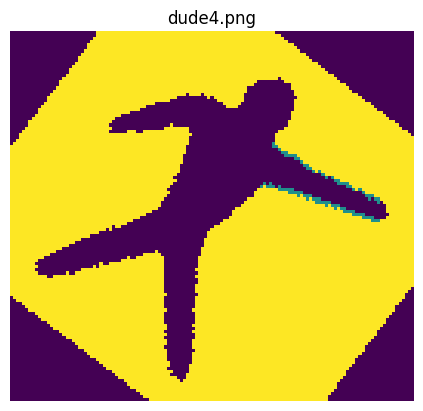

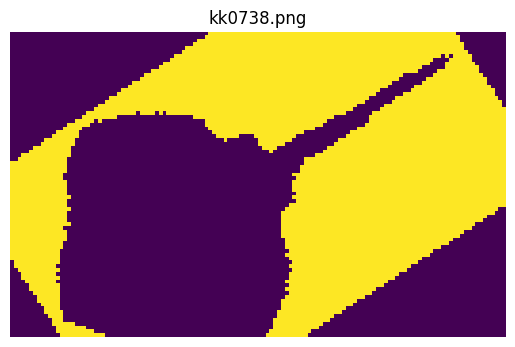

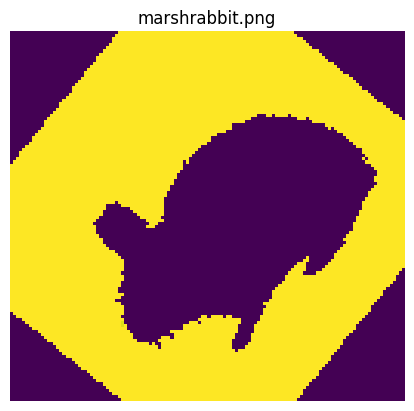

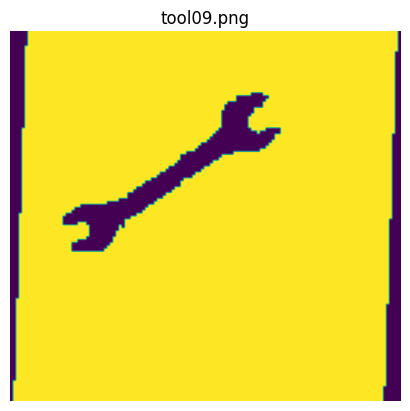

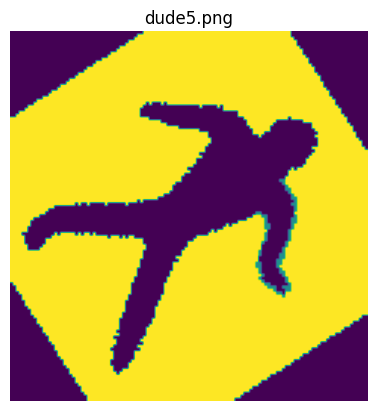

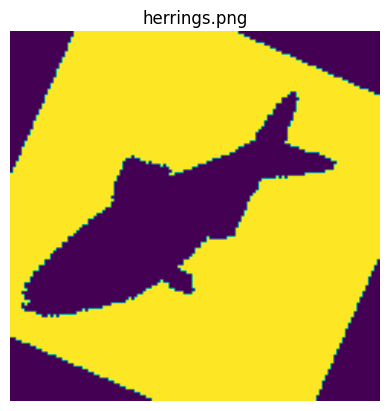

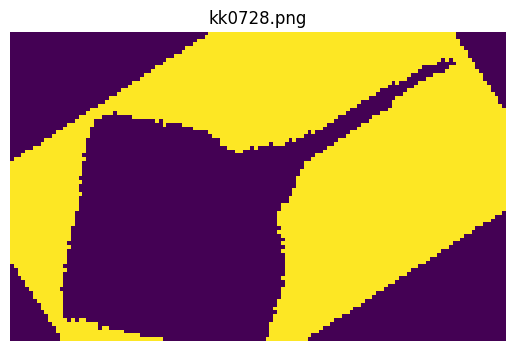

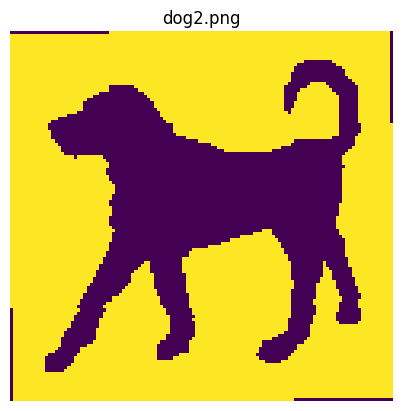

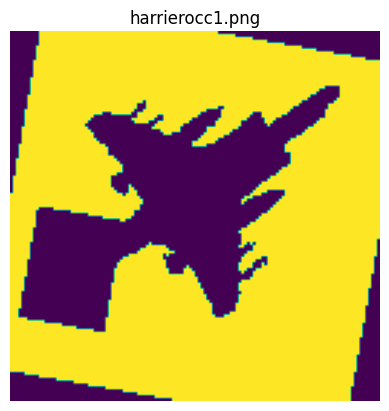

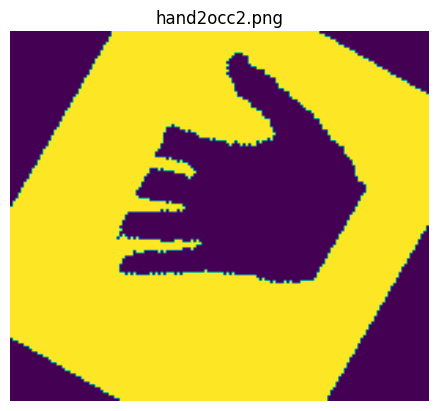

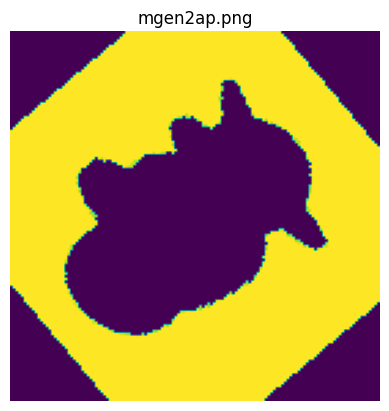

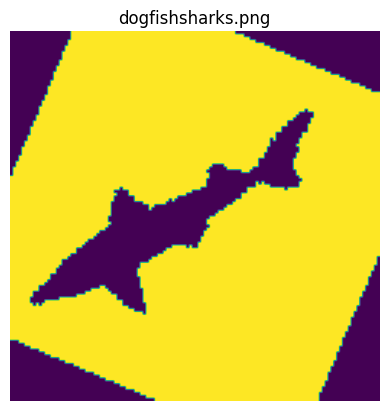

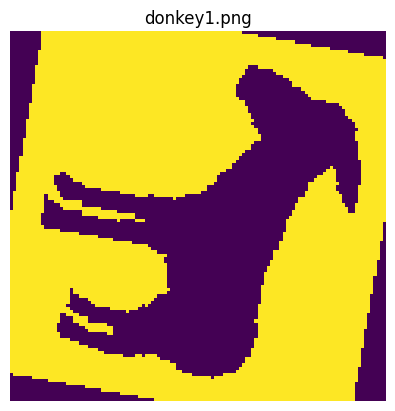

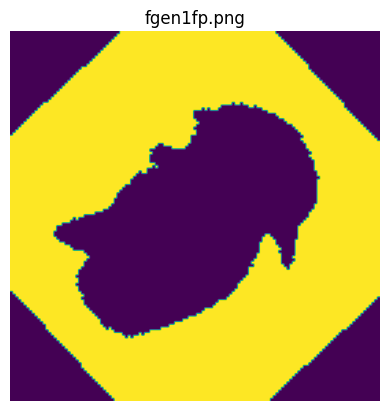

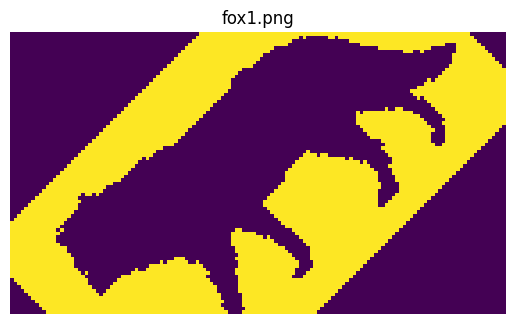

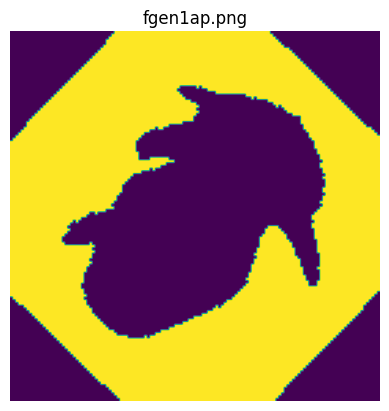

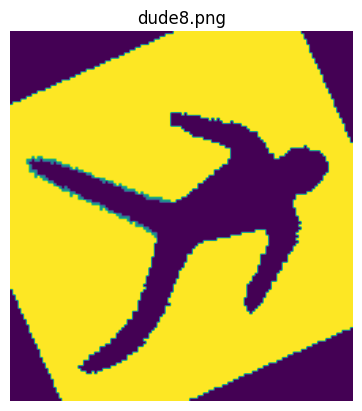

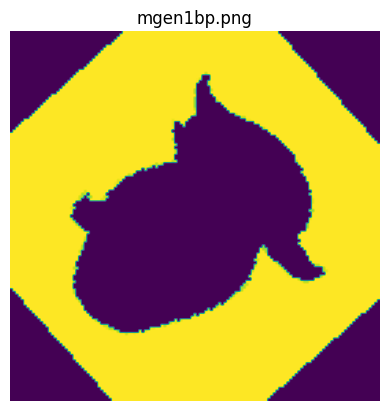

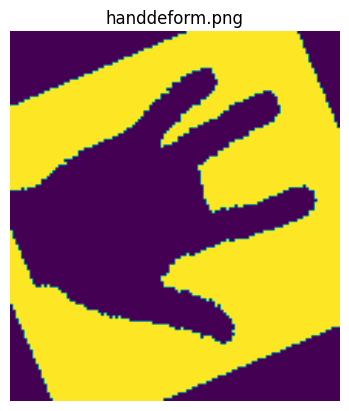

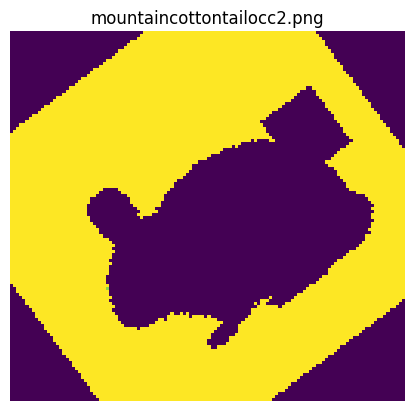

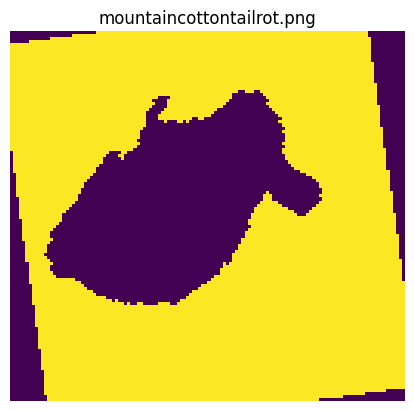

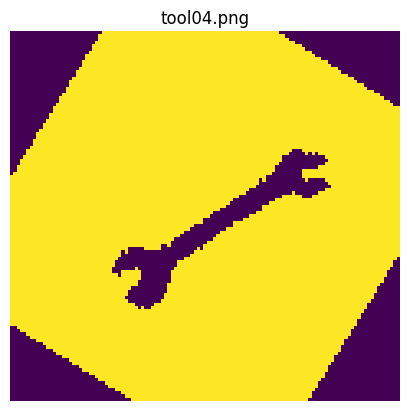

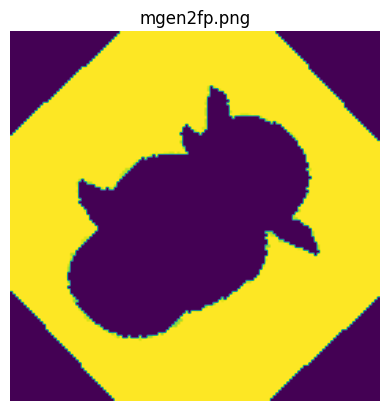

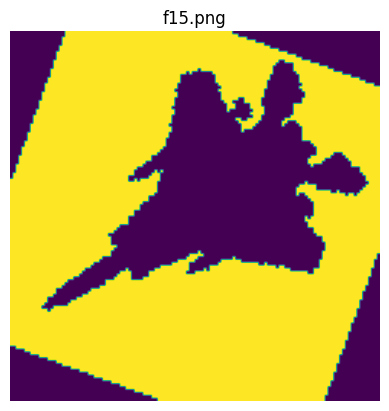

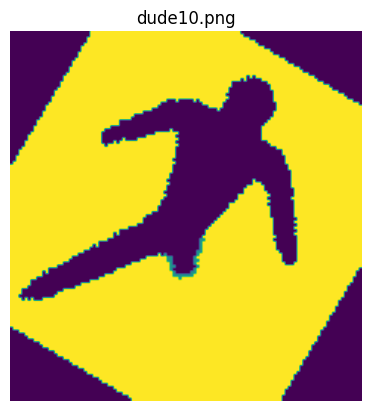

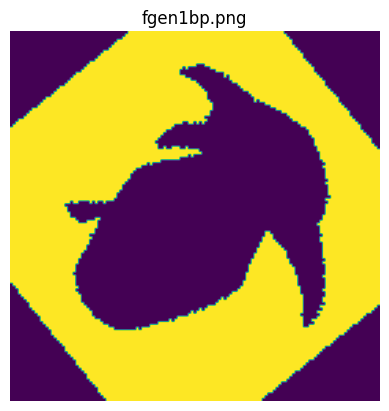

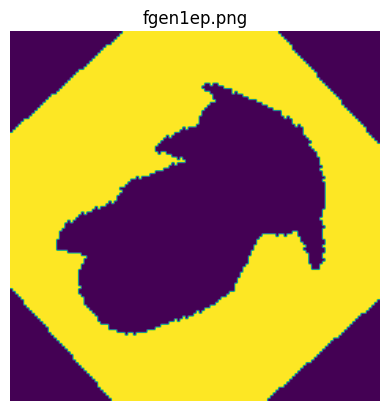

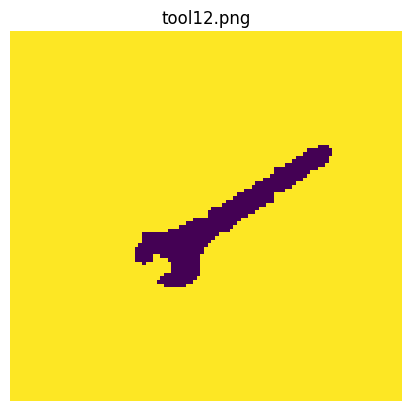

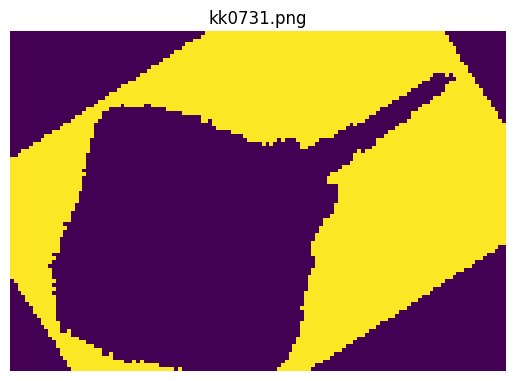

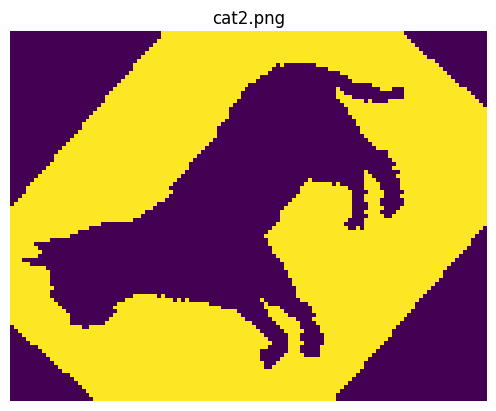

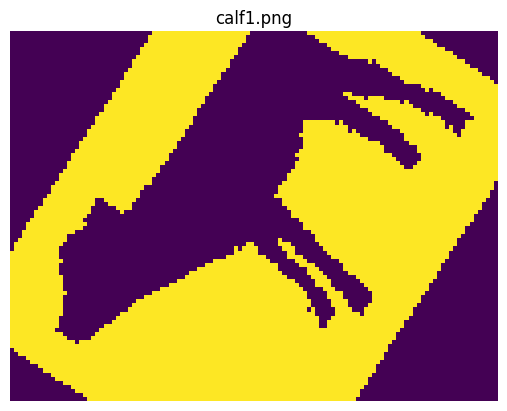

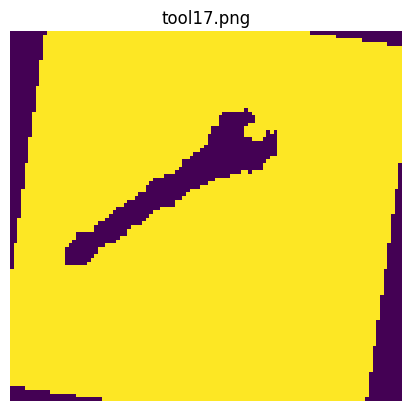

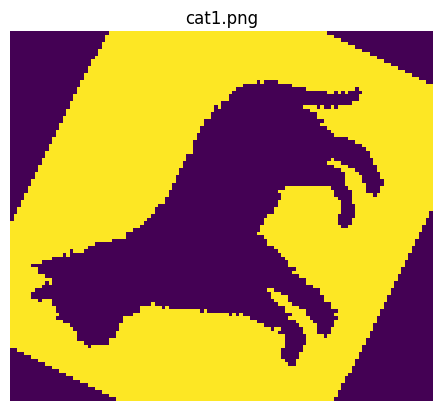

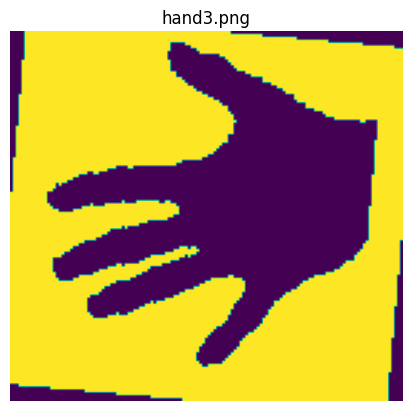

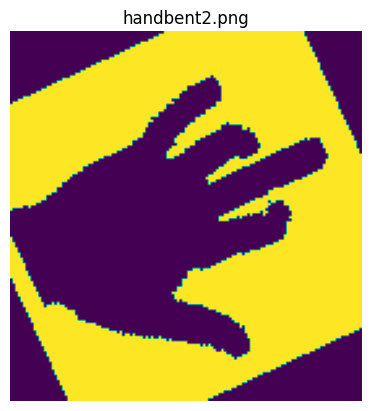

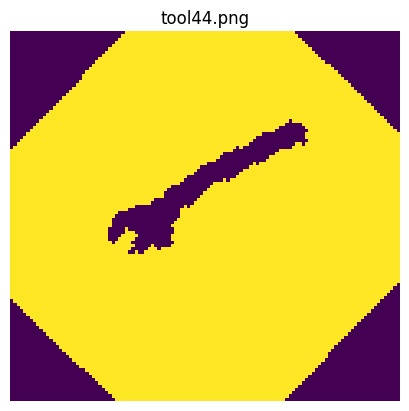

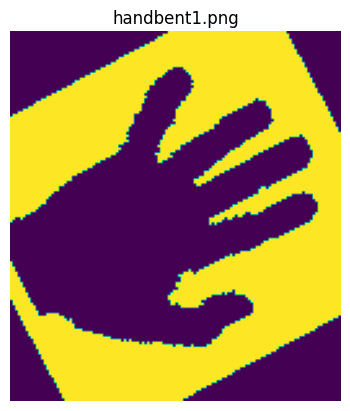

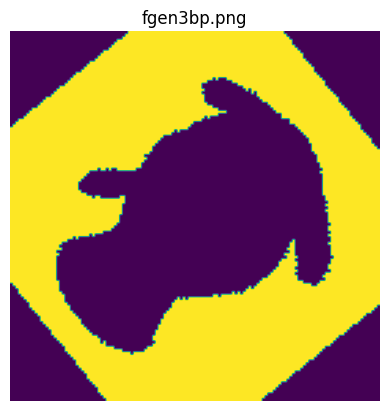

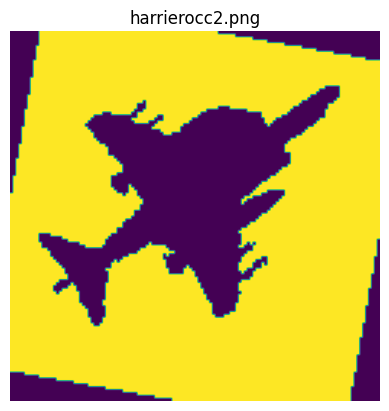

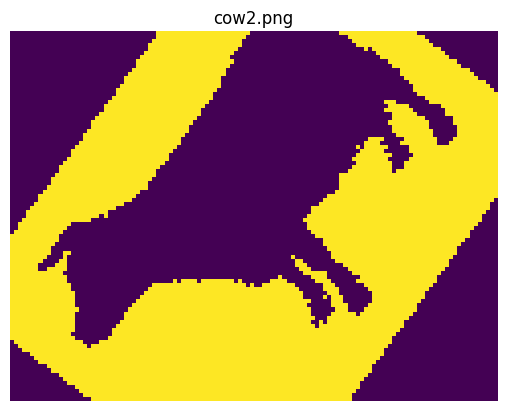

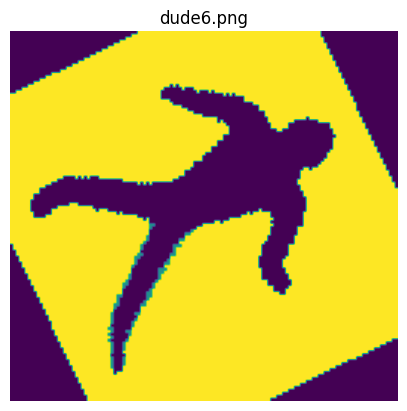

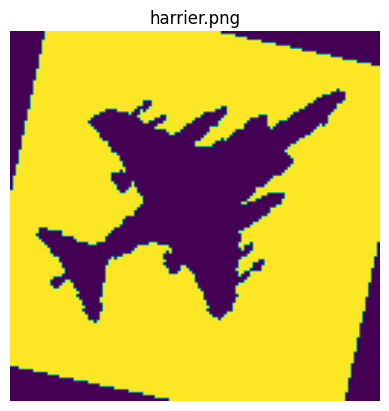

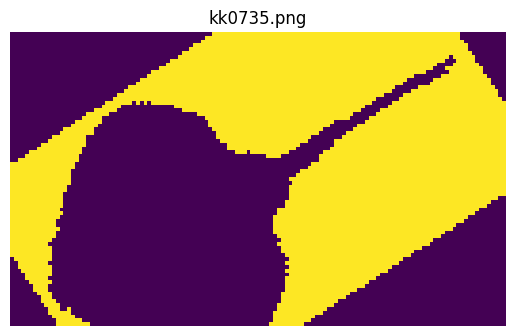

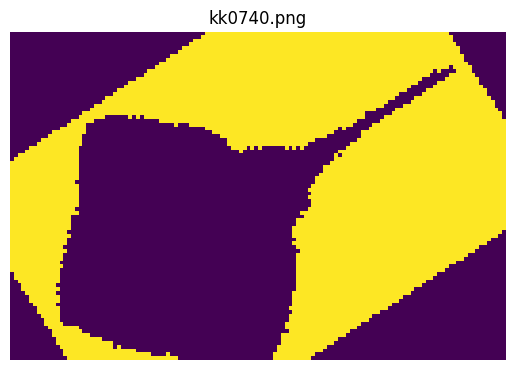

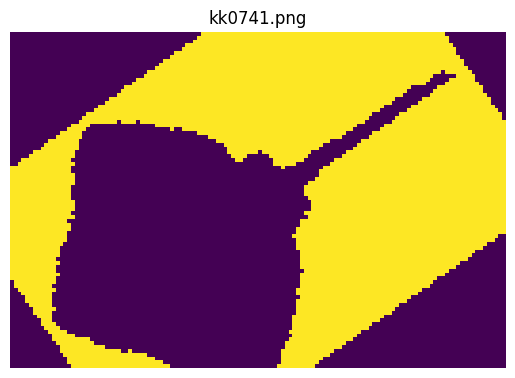

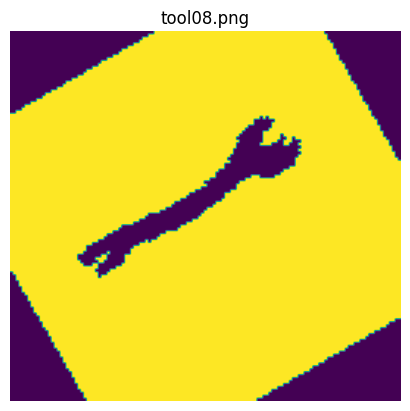

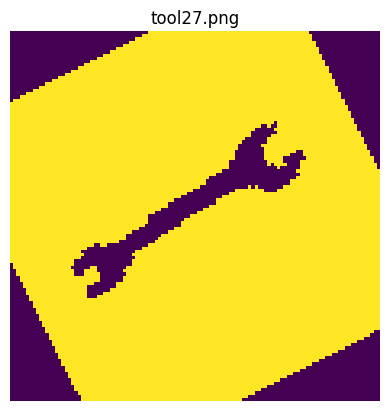

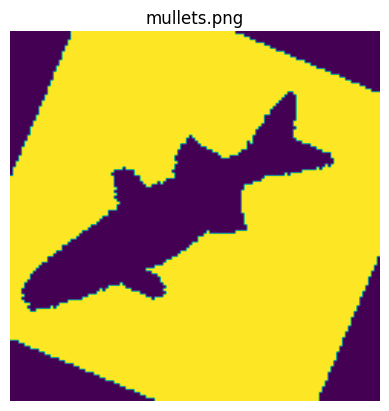

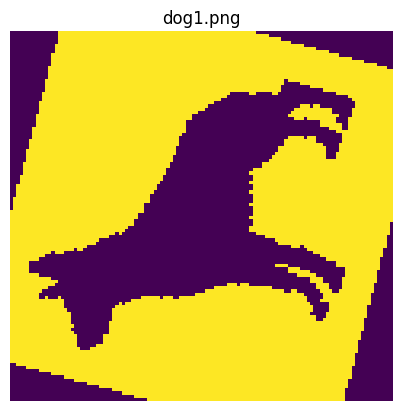

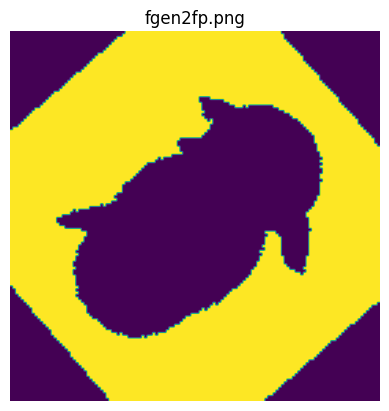

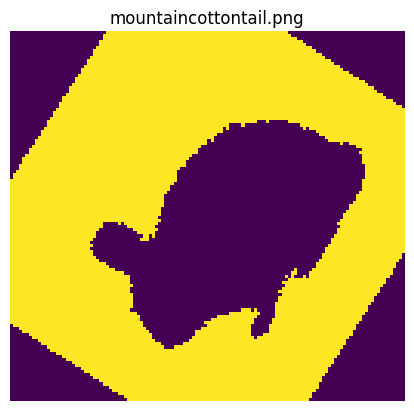

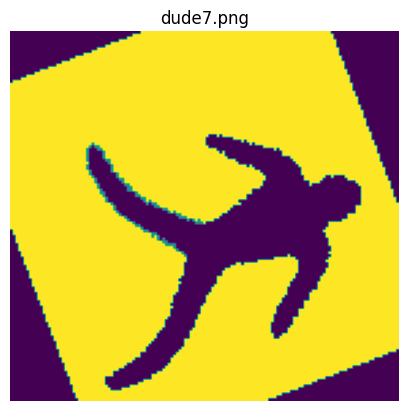

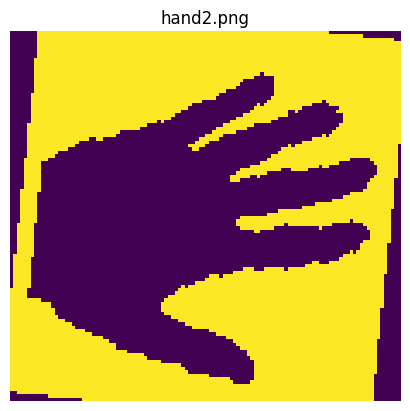

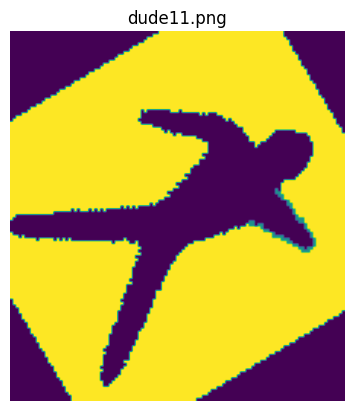

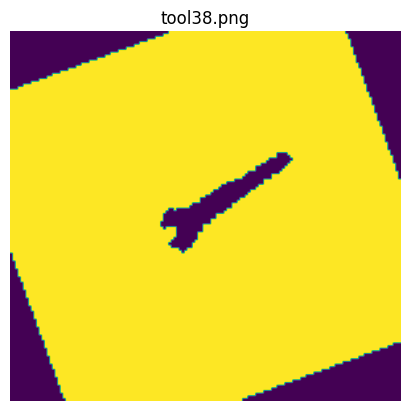

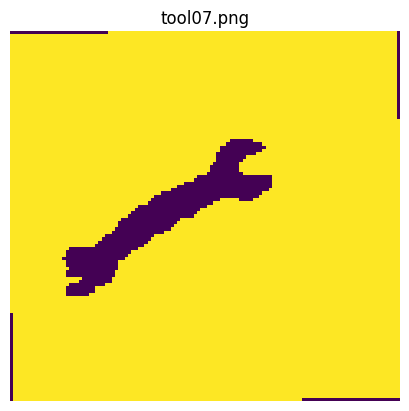

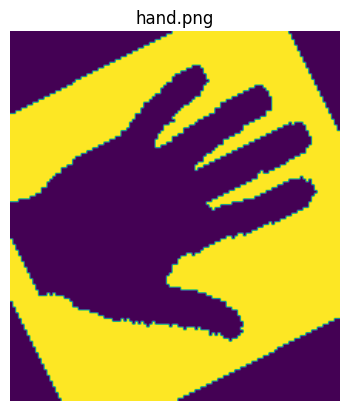

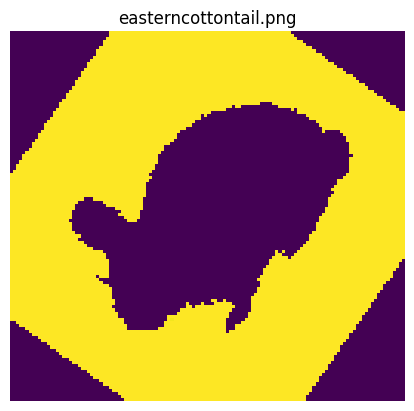

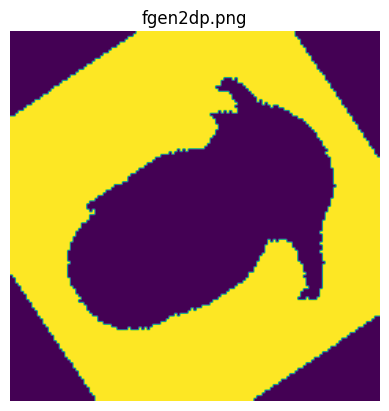

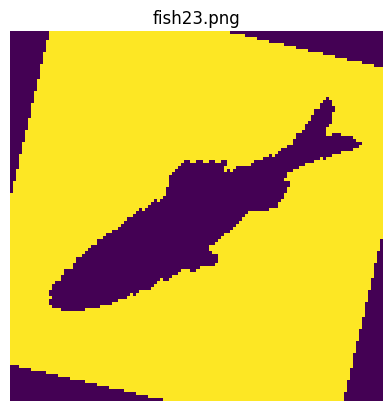

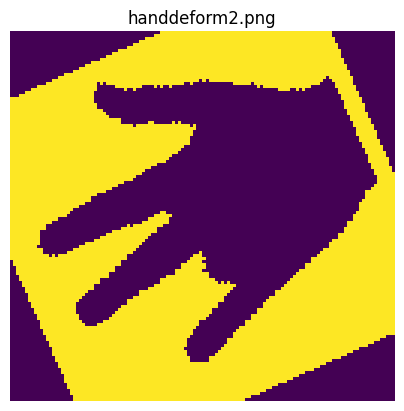

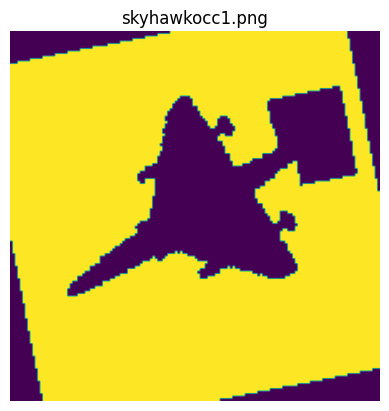

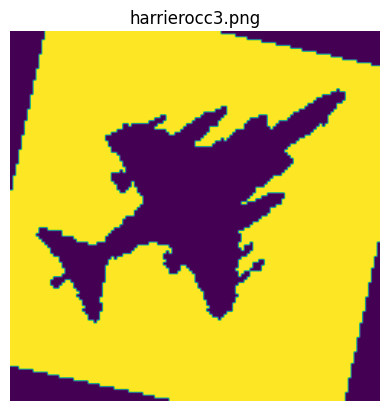

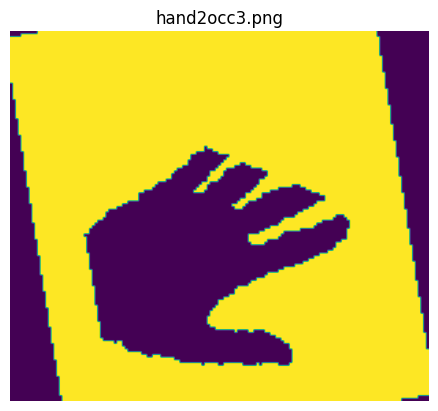

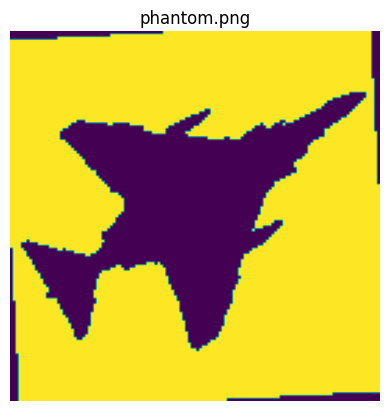

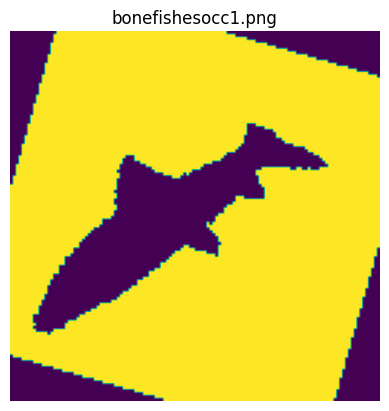

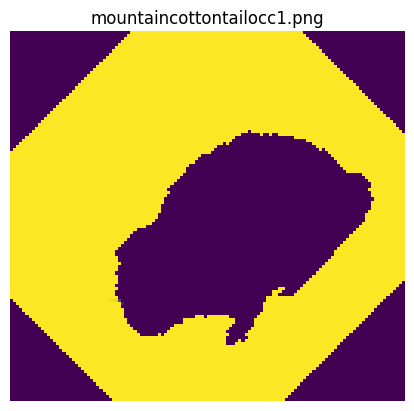

In [7]:
import cv2 as cv
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
def convert_from_cv2_to_image(image: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def convert_from_image_to_cv2(image: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)

def drawAxis(img,start_,end_,color,scale):
   start = list(start_)
   end = list(end_)
   dx = start[0]-end[0]
   dy = start[1]-end[1]

   hypotenuse = math.sqrt(dy**2 + dx**2)
   angle = math.atan2(dy,dx)
   # Lengthen the arrow by a factor of scale
   end[0] = start[0]-math.cos(angle)*hypotenuse*scale
   end[1] = start[1]-math.sin(angle)*hypotenuse*scale
   cv.line(img, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
   # Create the Arrow Hooks
   hook_length = 9
   angle_1 = math.pi/4+angle
   angle_2 = angle-math.pi/4

   x1 = end[0] + hook_length*math.cos(angle_1)
   y1 = end[1] + hook_length*math.sin(angle_1)
   x2 = end[0] + hook_length*math.cos(angle_2)
   y2 = end[1] + hook_length*math.sin(angle_2)
   cv.line(img, (int(x1), int(y1)), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
   cv.line(img, (int(x2), int(y2)), (int(end[0]), int(end[1])), color, 3, cv.LINE_AA)
    

def getOrientation(points,image):
   data_points = np.empty((len(points), 2), dtype=np.float64)
   for i in range(data_points.shape[0]):
    data_points[i,0] = points[i,0,0]
    data_points[i,1] = points[i,0,1]
   
   mean = np.empty((0))
   mean, eigenvectors, eigenvalues = cv.PCACompute2(data_points, mean)

   # Calculate the center of the object
   center = (int(mean[0, 0]), int(mean[0, 1]))
   cv.circle(image, center, 3, (255, 0, 255), 2)

   # Calculate the endpoints of the principal components
   p1 = (center[0] + 0.02 * eigenvectors[0, 0] * eigenvalues[0, 0], center[1] + 0.02 * eigenvectors[0, 1] * eigenvalues[0, 0])
   p2 = (center[0] - 0.02 * eigenvectors[1, 0] * eigenvalues[1, 0], center[1] - 0.02 * eigenvectors[1, 1] * eigenvalues[1, 0])

   # Draw the principal components
   drawAxis(image, center, p1, (255, 255, 0), 1)
   drawAxis(image, center, p2, (0, 0, 255), 5)

    # Calculate the orientation angle in radians
   angle = math.atan2(eigenvectors[0, 1], eigenvectors[0, 0])

    # Label with the rotation angle
   rotation_angle = -int(np.rad2deg(angle)) - 90
   label = f"Rotation Angle: {rotation_angle} degrees"
   print(label)

    # Draw a text box with the rotation angle
   textbox = cv.rectangle(image, (center[0], center[1] - 25), (center[0] + 250, center[1] + 10), (255, 255, 255), -1)
   cv.putText(image, label, (center[0], center[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)

   return str(rotation_angle)


def process_image(image_path):
    # Load the image
    image = cv.imread(image_path)
    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: File not found - {img_path}")
        return None
    # Convert the image to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Convert the image to binary using Otsu's thresholding
    _, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
    # Find all the contours in the thresholded image
    contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    max_area = 0
    max_orientation = 0
    # Iterate through the contours
    for i, c in enumerate(contours):
        # Calculate the area of each contour
        area = cv.contourArea(c)
        # Ignore contours that are too large
        if area > 10000:
            continue
        # Draw each contour only for visualization purposes
        cv.drawContours(image, contours, i, (0, 0, 255), 2)
        # Find the orientation of each shape
        orientation = getOrientation(c, image)
        if area > max_area:
            max_area = area
            max_orientation = orientation
    return max_orientation
      

folder_path = "KIMIA-99"
output_folder = "Image-KIMIA"
# Create the output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

processed_images = []
ans = process_image("KIMIA-99/tool12.png")

# Iterate through all PNG files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        file_path = os.path.join(folder_path, filename)
        # Process the image and get the orientation
        orientation = process_image(file_path)
        difference = int(ans)-int(orientation)
        original_image = Image.open(file_path)
        rotated_image = original_image.rotate(difference)
        # Save the rotated image
        output_file_path = os.path.join(output_folder, filename)
        rotated_image.save(output_file_path)
        processed_images.append((filename, output_file_path))

# Close OpenCV windows after processing
cv.destroyAllWindows()

# Display all processed images with labels
for filename, img_path in processed_images:
    img = Image.open(img_path)
    plt.figure()
    plt.title(filename)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# 4.2 - Hierarchial Clustering 

# 4.3 - Guassian Mixture Models

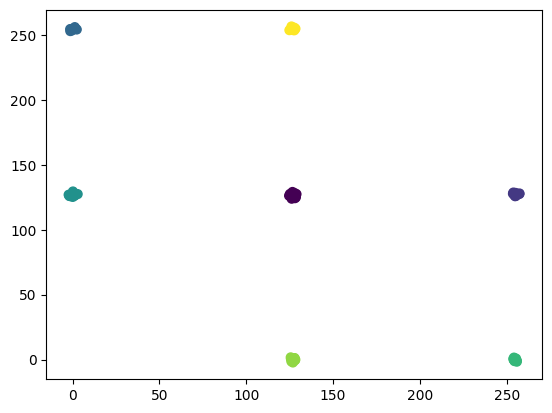

In [3]:

from sklearn.mixture import GaussianMixture
with open('colors.pkl', 'rb') as f:
    data = np.array(pickle.load(f))

X = data
gm = GaussianMixture(n_components=7, random_state=0).fit(X)
labels = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

/tmp/ipykernel_56408/874171567.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')


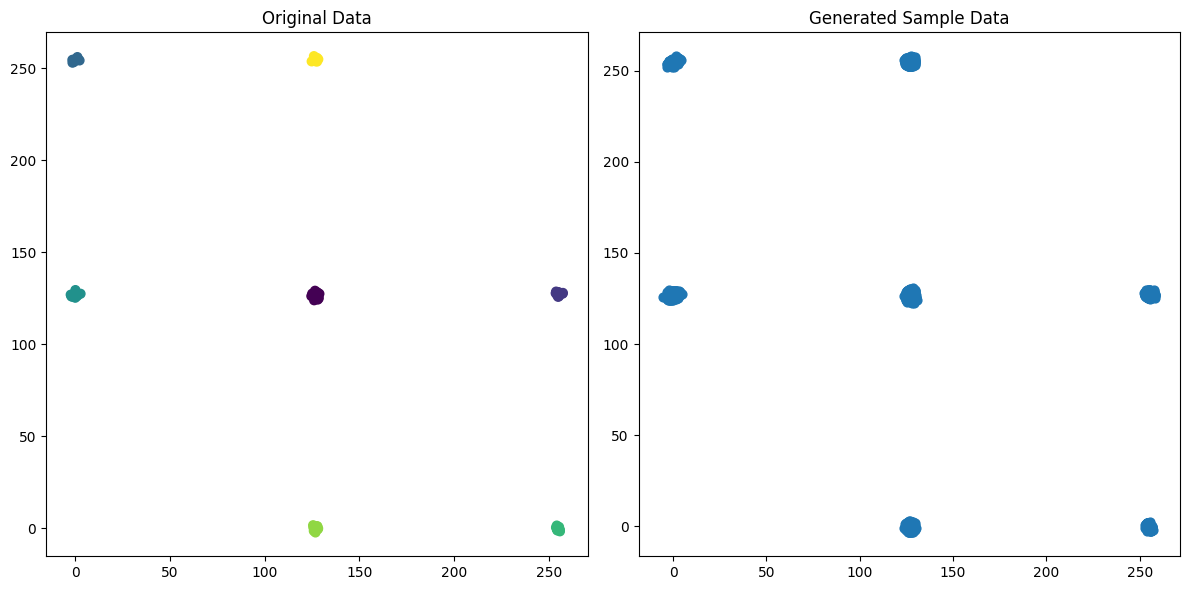

In [11]:
def generate_dataset(number_of_components,means,covariances,num_samples=1000):
    new_dataset = []
    for component in range(number_of_components):
        new_dataset.append(np.random.multivariate_normal(means[component],covariances[component],num_samples))
    return np.vstack(new_dataset)

new_dataset = generate_dataset(7,gm.means_,gm.covariances_)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.scatter(new_dataset[:, 0], new_dataset[:, 1], s=40, cmap='viridis')
plt.title('Generated Sample Data')

plt.tight_layout()
plt.show()